Для работы демки требуется:
- python 3
- ipywidgets 6.0.0 ("git clone https://github.com/ipython/ipywidgets" , "cd ipywidgets", "pip install .")
- удача :D

Допускаю возможность что у кого-то демо не заработает (отсутсвие библиотек или возможные сбои js), поэтому **в архиве приложено видео с работой демки :)**

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import pickle
from scipy import stats
import statsmodels.api as sm
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.cluster
import sklearn.model_selection
from sklearn.base import clone
from sklearn.externals import joblib
import pandas.tseries.holiday
from pandas.tseries.holiday import USFederalHolidayCalendar

Populating the interactive namespace from numpy and matplotlib


#### Загружаем данные (оставляем только нужные регионы)

In [2]:
bins = pd.read_csv('3_years_bins.csv', index_col='hour_id')
bins.index = pd.DatetimeIndex(bins.index, freq='H')
region_ids = list(bins.columns)
bins_orig = bins.copy()

#### Функции для подготовки и обработки данных

In [3]:
# Константы
class exConsts():
    lx = -74.25559 #left x
    rx = -73.70001 #right x
    by = 40.49612 # bottom y
    ty = 40.91553 # top y
    intervals_cnt = 50
    regions_cnt = intervals_cnt*intervals_cnt
    dx = (rx-lx)/intervals_cnt
    dy = (ty-by)/intervals_cnt
    #New York Pos
    ny_x = (lx+rx)*0.5
    ny_y = (by+ty)*0.5 #new york y

def region_id_to_bounds(region):
    x = int((region-1)/exConsts.intervals_cnt)*exConsts.dx+exConsts.lx
    y = int((region-1)%exConsts.intervals_cnt)*exConsts.dy+exConsts.by
    return x,y,x+exConsts.dx,y+exConsts.dy
    
def region_to_xy(region):
    x = int((int(region)-1)/exConsts.intervals_cnt)
    y = int((int(region)-1)%exConsts.intervals_cnt)
    return x,y

def xy_to_region(x,y):
    return str(x*exConsts().intervals_cnt+y+1)

In [4]:
from IPython.display import HTML,Javascript,display

#Небольшой класс для работы с Яндекс.Картам
class yamap():
    __map_count = 0
    def __init__(self):
        display(Javascript("requirejs.config({paths:{'ymap': ['https://api-maps.yandex.ru/2.1/?lang=ru_RU']},});"))
        self.name = "yamap%d"%(yamap.__map_count)
        self.acc_js = ""
        self.is_update = False
        yamap.__map_count += 1
    def _ready_js(self,js):
        if (self.is_update):
            self.acc_js += js
        else:
            display(Javascript('''require(['ymap'], function(ymap) {ymaps.ready(function () {%s});});'''%(js)))
    def begin_update(self):
        self.is_update = True
        self.acc_js = ""
    def end_update(self):
        self.is_update = False
        if (len(self.acc_js)>0):
            self._ready_js(self.acc_js)
            self.acc_js = ""
    def show(self,x=37.64,y=55.76,zoom=11,map_options='controls:["zoomControl"]'):
        self._ready_js('''
        $("#%(divid)s").remove();
        element.append("<div id='%(divid)s' style='width:960px;height:600px;'></div>");
        window.%(mapid)s = new ymaps.Map('%(divid)s', {center: [%(y)f,%(x)f],zoom: %(zoom)d,%(map_options)s});
        '''%{'divid':'div-'+self.name,'mapid':self.name,'x':x,'y':y,'zoom':zoom,'map_options':map_options})
        return self
    #Добавление прямоугольников паком
    def addRectangles(self,bounds_list,properties_list=[],options_list=[]):
        rect_data_str = ''
        if (len(properties_list)!=len(bounds_list)): properties_list=['']*len(bounds_list)
        if (len(options_list)!=len(bounds_list)): options_list=['']*len(bounds_list)
        for i in range(len(bounds_list)):
            y1,x1,y2,x2 = bounds_list[i]
            rect_data_str += '''{type: 'Feature',id: %d,geometry:{type: 'Rectangle',coordinates: [[%f,%f],[%f,%f]]},properties:{%s},options:{%s}},'''%(i,x1,y1,x2,y2,properties_list[i],options_list[i])
        js_code = \
            '''var collection = {type: 'FeatureCollection',features: [%s]},
            myObjectManager = new ymaps.ObjectManager();
            myObjectManager.add(collection);
            %s.geoObjects.add(myObjectManager);'''%(rect_data_str,self.name)
        self._ready_js(js_code)
    #Добавление прямоугольников паком
    def clearGetObjects(self):
        js_code = '''%s.geoObjects.removeAll();'''%(self.name)
        self._ready_js(js_code)
        
#функция обучает регрессию и возвращает результаты из тестовой выборки словарем регионов
def data_to_predicted_dict(region_features, region_answers, region_features_test, est, region_ids):
    predicted_df_dict = dict()
    for region in region_ids:
        clf_arr = []
        for i in range(6):
            clf = clone(est)
            clf.fit(region_features[region].values, region_answers[region].values[:,i])
            clf_arr.append(clf)

        predicted = np.maximum(0.0, np.array([clf_arr[i].predict(region_features_test[region].values) for i in range(6)]).T.reshape(-1))
        predicted_index = [cur_time+relativedelta(hours=hours_shift) for cur_time in region_features_test[region].index for hours_shift in range(0,6)]
        predicted_df_dict[region] = pd.DataFrame(predicted, index=predicted_index, columns=['pred'])
    return predicted_df_dict

#результаты в формате словаря регионов конвертируются в Q метрику
def predicted_dict_to_Q(pred_dict, region_ids):
    return np.mean([np.mean(np.abs(bins_orig[region][pred_dict[region].index].values-pred_dict[region].values.squeeze())) for region in region_ids])

#результаты в формате словаря регионов конвертируются в формат соревнования на kaggle
def predicted_dict_to_kaggle_file(pred_dict, filename):
    f = open(filename, 'w')
    f.write('id,y\n')
    j = 1
    for region in region_ids:
        pdf = pred_dict[region]
        for i in range(len(pdf)):
            cur_time = pdf.index[int(i/6)*6]-relativedelta(hours=1)
            cur_pred = pdf.values.squeeze()[i]
            f.write('%s_%d-%02d-%02d_%d_%d,%d\n'%(
                    region, #Номер региона, нумерация с 0
                    cur_time.year,
                    cur_time.month,
                    cur_time.day,
                    cur_time.hour,
                    j,
                    np.maximum(0,cur_pred+0.5))) #Убираем отрицательные предсказания и округляем до целочисленного
            j = j%6+1
    f.close()

def get_features_df(bins_index):
    new_features_data = []
    #Добавляем признак часа
    new_features_data.append(pd.get_dummies(bins_index.hour, prefix='hour'))
    #Добавляем признак дня недели
    new_features_data.append(pd.get_dummies(bins_index.weekday, prefix='weekday'))
    #Добавляем признак месяца
    new_features_data.append(pd.get_dummies(bins_index.month, prefix='month'))

    holiday_index = USFederalHolidayCalendar().holidays(bins_index[0], bins_index[-1])
    #Добавляем признак праздника следующего дня
    new_features_data.append(pd.Series(bins_index, name='holiday_next_day').apply(lambda x: int((x+relativedelta(hour=0, days=1)) in holiday_index)))
    #Добавляем признак праздника текущего дня
    new_features_data.append(pd.Series(bins_index, name='holiday_cur_day').apply(lambda x: int((x+relativedelta(hour=0, days=0)) in holiday_index)))
    #Добавляем признак праздника прошлого дня
    new_features_data.append(pd.Series(bins_index, name='holiday_prev_day').apply(lambda x: int((x+relativedelta(hour=0, days=-1)) in holiday_index)))
    
    new_features_df = pd.concat(new_features_data, axis=1)
    new_features_df.index = bins_index
    return new_features_df

In [5]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [6]:
def get_training_data(start_time, end_time, region):
    hours_before = 24*7
    sid = np.where(bins.index==pd.to_datetime(start_time))[0][0]-hours_before
    eid = np.where(bins.index==pd.to_datetime(end_time))[0][0]+6

    data_arr = []
    history_data = rolling_window(bins[region][sid:eid], hours_before+6)
    history_y = history_data[:,hours_before:]
    data_arr.append(history_data[:,:hours_before])
      
    #Добавляем календарные данные
    history_idx = bins.index[sid+hours_before:sid+hours_before+len(history_data)]
    data_arr.append(new_features_df[sid+hours_before:sid+hours_before+len(history_data)])

    return pd.DataFrame(np.hstack(data_arr), history_idx), pd.DataFrame(history_y, history_idx)

In [7]:
def get_training_dict(start_time, end_time):
    region_features = dict()
    region_answers = dict()
    for region in region_ids:
        X, y = get_training_data(start_time, end_time, region)
        region_features[region] = X
        region_answers[region] = y
    return region_features, region_answers

In [8]:
new_features_df = get_features_df(bins.index)
new_features_cols = list(new_features_df.columns)

In [9]:
region_features, region_answers = get_training_dict('2015-05-01 00:00:00', '2016-04-30 18:00:00')
region_features_may, _ = get_training_dict('2016-05-01 00:00:00', '2016-05-31 18:00:00')

#### Подготовка xgboost для предсказания поездок по истории

In [10]:
import xgboost as xgb


C:\_dev\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
import xgboost as xgb
est_dict = dict()
for region in region_ids:
    est_arr = []
    for i in range(6):
        est = xgb.XGBRegressor().fit(region_features[region].values, region_answers[region].values[:,i])
        est_arr.append(est)
    est_dict[region] = est_arr

C:\_dev\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
import sklearn.externals.joblib
est_dict = joblib.load('est_dict.dmp')

#### Подготовка линейного классификатора (для предсказания поездок без априорных данных)

In [13]:
est_lin_dict = dict()
for region in region_ids:
    est = sklearn.linear_model.LinearRegression()
    est.fit(new_features_df, bins[region])
    est_lin_dict[region] = est

In [14]:
def data_to_predicted_dict(region_features_test, region_ids):
    predicted_df_dict = dict()
    for region in region_ids:
        clf_arr = est_dict[region]
        predicted = np.maximum(0.0, np.array([clf_arr[i].predict(region_features_test[region].values) for i in range(6)]).T.reshape(-1))
        predicted_index = [cur_time+relativedelta(hours=hours_shift) for cur_time in region_features_test[region].index for hours_shift in range(0,6)]
        predicted_df_dict[region] = pd.DataFrame(predicted, index=predicted_index, columns=['pred'])
    return predicted_df_dict

In [15]:
region_features_may, _ = get_training_dict('2016-05-01 00:00:00', '2016-05-01 00:00:00')
pdf_may = data_to_predicted_dict(region_features_may, region_ids)
region_total_arr = [np.sum(pdf_may[region].values) for region in region_ids]

In [16]:
def get_forecast_dict(forecast_date):
    forecast_pos = np.where(bins.index==pd.to_datetime(forecast_date))[0]
    if len(forecast_pos)>0:
        forecast_pos = forecast_pos[0]
    else:
        forecast_pos = -1
    sid = forecast_pos-24*7
    eid = forecast_pos+6
    if ((0<=sid) & (eid<len(bins))):
        region_features, _ = get_training_dict(forecast_date, forecast_date)
        return data_to_predicted_dict(region_features, region_ids)
    else:
        forecast_index = pd.date_range(forecast_date, pd.to_datetime(forecast_date)+relativedelta(hours=5), freq='H')
        cur_features_part = get_features_df(forecast_index)
        cur_features_df = pd.DataFrame(0, index=cur_features_part.index, columns=new_features_cols)
        for col in cur_features_part.columns: cur_features_df[col] = cur_features_part[col]
        return {region:pd.DataFrame(np.maximum(0, est_lin_dict[region].predict(cur_features_df).astype(int)), index=cur_features_df.index) for region in region_ids}

# Визуализация данных на карте

In [17]:
# region_colors = [matplotlib.colors.rgb2hex(color[:3]) for color in plt.get_cmap('gist_ncar')(np.linspace(0, 1, max(region_clusters)+1))]
# region_colors = [matplotlib.colors.rgb2hex(color[:3]) for color in plt.get_cmap('gist_ncar')(np.random.rand(max(region_clusters)+1,))]
def getNewJSData(forecast_date):
    pdf_may = get_forecast_dict(forecast_date)
    region_total_arr = [np.sum(pdf_may[region].values) for region in region_ids]
    max_min_diff = np.max(region_total_arr)-np.min(region_total_arr)
    region_bounds = np.array([region_id_to_bounds(int(str)) for str in region_ids])
    region_options = np.array(['fillColor:"F00",fillOpacity:%f,strokeOpacity:%f'%(0.1+0.9*(region_total_arr[i]-np.min(region_total_arr))/max_min_diff,0.4) for i in range(len(region_ids))])
    region_props = np.array(['hintContent: "<b>Region %s</b>:<br>%s"'%(region,'<br>'.join(['%s: %d'%(pdf_may[region].index[i], pdf_may[region].values[i]) for i in range(6)])) for region in region_ids])
    return region_bounds, region_props, region_options


region_bounds, region_props, region_options = getNewJSData('2016-05-01 00:00:00')
cluster_map = yamap()
cluster_map.begin_update()
cluster_map.show(exConsts.ny_x, exConsts.ny_y)
cluster_map.addRectangles(region_bounds, region_props, region_options)
cluster_map.end_update()

import ipywidgets as widgets
date_widget = widgets.DatePicker(description='Дата')
date_widget.value = datetime.datetime(2016, 1, 4, 0, 0)
hour_widget = widgets.IntSlider(value=7, min=0, max=23, step=1, description='Час:',)

cur_date = datetime.datetime(date_widget.value.year, date_widget.value.month, date_widget.value.day, hour_widget.value)
def on_value_change(change):
    new_date = datetime.datetime(date_widget.value.year, date_widget.value.month, date_widget.value.day, hour_widget.value)
    global cur_date
    if new_date!=cur_date:
        cur_date = new_date
        region_bounds, region_props, region_options = getNewJSData(str(cur_date))
        cluster_map.begin_update()
        cluster_map.clearGetObjects()
        cluster_map.addRectangles(region_bounds, region_props, region_options)
        cluster_map.end_update()
date_widget.observe(on_value_change)
hour_widget.observe(on_value_change)
display(date_widget, hour_widget)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Допускаю возможность что у кого-то демо не заработает (отсутсвие библиотек или возможные сбои js), поэтому приложено видео с работой :)

# Визуализация данных временным рядом

In [18]:
from ipywidgets import interact, interactive, fixed

from IPython.display import clear_output, display

In [102]:
def plot_forecast(region, forecast_date):
    forecast_pos = np.where(bins.index==pd.to_datetime(forecast_date))[0]
    if len(forecast_pos)>0:
        forecast_pos = forecast_pos[0]
    else:
        forecast_pos = -1
    sid = forecast_pos-24*7
    eid = forecast_pos+6
    
    forecast_6h = None
    if ((0<=sid) & (eid<len(bins))):
        region_features, _ = get_training_dict(forecast_date, forecast_date)
        forecast_6h = data_to_predicted_dict(region_features, [region])

    forecast_index = pd.date_range(forecast_date-relativedelta(hours=24), pd.to_datetime(forecast_date)+relativedelta(hours=5), freq='H')
    cur_features_part = get_features_df(forecast_index)
    cur_features_df = pd.DataFrame(0, index=cur_features_part.index, columns=new_features_cols)
    for col in cur_features_part.columns: cur_features_df[col] = cur_features_part[col]
    forecast_lin = pd.DataFrame(np.maximum(0, est_lin_dict[region].predict(cur_features_df).astype(int)), index=cur_features_df.index)
    plt.figure(figsize=(12,2.5))
    plt.plot(bins[region][forecast_index], 'b', label='Real data')
    plt.plot(forecast_lin, 'g', label="Forecast (withot history)")
    if forecast_6h is not None:
        plt.plot(forecast_6h[region], 'r', linewidth=2.0, label="Forecast (with history)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    clear_output(True)
#     plt.draw()

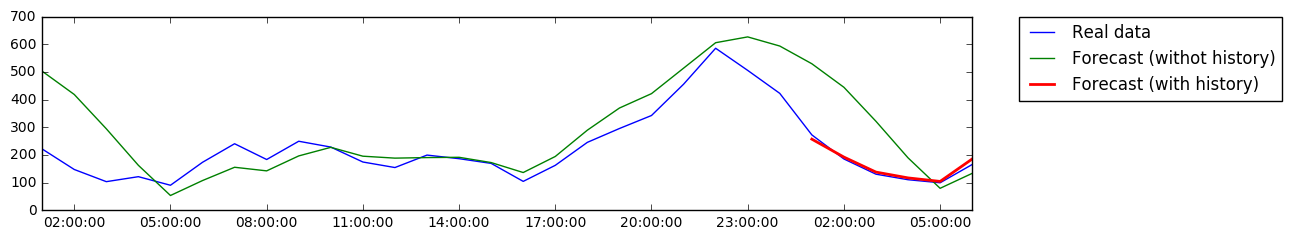

In [104]:
region_slider = widgets.SelectionSlider(options=region_ids, value=region_ids[0], description='Region:', continuous_update=False, orientation='horizontal',)
import ipywidgets as widgets
date_widget = widgets.DatePicker(description='Дата')
date_widget.value = datetime.datetime(2016, 1, 4, 0, 0)
hour_widget = widgets.IntSlider(value=7, min=0, max=23, step=1, description='Час:',)

cur_region = region_ids[0]
cur_date = datetime.datetime(date_widget.value.year, date_widget.value.month, date_widget.value.day, hour_widget.value)
def on_value_change(change):
    new_date = datetime.datetime(date_widget.value.year, date_widget.value.month, date_widget.value.day, hour_widget.value)
    global cur_region
    global cur_date
    if ((new_date!=cur_date) | (cur_region!=region_slider.value)):
        cur_date = new_date
        cur_region = region_slider.value
        plot_forecast(cur_region, cur_date)
region_slider.observe(on_value_change)
date_widget.observe(on_value_change)
hour_widget.observe(on_value_change)
display(region_slider, date_widget, hour_widget)
plot_forecast(cur_region, cur_date)